In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import scipy.stats as sp 
import matplotlib.pyplot as plt 
from IPython.display import clear_output #

In [2]:
uncentered_gaussian = np.random.normal(loc= 5, scale=2 , size=10000)
dist = np.random.normal(size= (10000, 19))
dist = np.hstack((uncentered_gaussian.reshape(-1,1), dist))
dist.shape

(10000, 20)

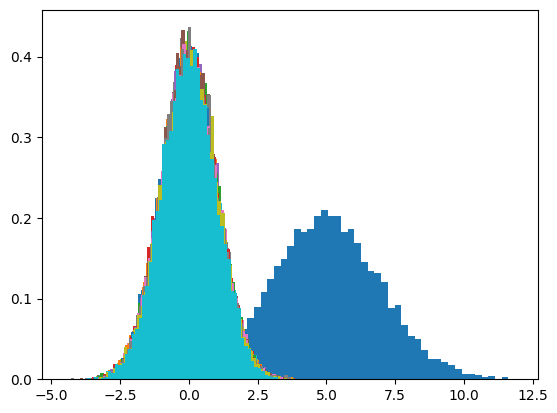

In [3]:
for i in range(20):
    plt.hist(dist[:, i],bins= 'auto', density=True, label= r'$density_%d$'%i);

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0] 
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape= (batch, dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

In [5]:
class Encoder(layers.Layer):
  def __init__(self, latent_dim, **kwargs):
    super(Encoder, self).__init__(name='encoder', **kwargs)
    self.enc1 = layers.Dense(20, activation='relu')
    self.enc2 = layers.Dense(10, activation = 'relu')
    self.enc3 = layers.Dense(5, activation = 'relu')
    self.mean_z = layers.Dense(latent_dim, name = 'z_mean')
    self.logvar_z = layers.Dense(latent_dim)
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.enc1(inputs)
    x = self.enc2(x)
    x = self.enc3(x)
    z_mean = self.mean_z(x)
    z_log_var = self.logvar_z(x)
    z = self.sampling([z_mean, z_log_var])
    return z_mean, z_log_var, z

In [6]:
class Decoder(layers.Layer):

 def __init__(self,latent_dim, **kwargs):
    super(Decoder, self).__init__(name='decoder', **kwargs)
    self.dec1 = layers.Dense(latent_dim, activation='relu')
    self.dec2 = layers.Dense(5, activation='relu')
    self.dec3 = layers.Dense(10, activation='relu')
    self.out = layers.Dense(20, name = 'x_out')
    self.x_log_var = layers.Dense(20, name = 'x_log_var')

 def call(self, z):
   z = self.dec1(z)
   z = self.dec2(z)
   z = self.dec3(z)
   return self.out(z), self.x_log_var(z)

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder,optimizer, **kwargs):
        super(VAE, self).__init__(name = 'vae', **kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.optimizer = optimizer
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name = 'Total_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name = 'kl_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name = 'reconstruction_loss')
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction, x_log_var = self.decoder(z)
        return z_mean, z_log_var, reconstruction, x_log_var
    
    def get_encoder_decoder():
        return encoder, decoder
    
    def train_step(self, data):
        with tf.GradientTape() as tape :
            z_mean, z_log_var, reconstruction, x_log_var = self(data) 
            #we compute the first loss : the log-likelyhood 
            scale_x = tf.exp(x_log_var) #variance 
            log_pdf = 0.5 * tf.reduce_sum(tf.pow(data-reconstruction, 2) / scale_x + x_log_var, axis = 1) #-log_pdf because wze want to maximise it (SGD aim to minimize in keras)
            reconstruction_loss =  tf.reduce_mean(log_pdf)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(   -.5 * (1 +  z_log_var - tf.square(z_mean) - tf.exp(z_log_var))  )) #computing kl_analytique expression for each observation
            total_loss = reconstruction_loss + kl_loss
            self.add_loss(total_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
        

In [8]:
encoder = Encoder(2)
decoder = Decoder(2)

In [9]:
vae = VAE(encoder, decoder, tf.keras.optimizers.Adam(learning_rate= 1e-3))

In [10]:
######## Training #########
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3))
history = vae.fit(dist,epochs=20,
    batch_size=32,
    shuffle=True)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Total_loss: 21.1415 - kl_loss: 1.7873 - loss: 0.0000e+00 - reconstruction_loss: 19.3542
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Total_loss: 11.2989 - kl_loss: 0.0212 - loss: 0.0000e+00 - reconstruction_loss: 11.2777
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Total_loss: 10.9059 - kl_loss: 0.0049 - loss: 0.0000e+00 - reconstruction_loss: 10.9010
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Total_loss: 10.7951 - kl_loss: 0.0015 - loss: 0.0000e+00 - reconstruction_loss: 10.7936
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - Total_loss: 10.7606 - kl_loss: 8.2358e-04 - loss: 0.0000e+00 - reconstruction_loss: 10.7598
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Total_loss: 10.7797 - kl_loss: 5.0806e-04 - loss: 0.0000e+00 - reconstruction_loss: 10.7792
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 10.7552 - kl_loss: 1.8608e-04 - loss: 0.0000e+00 - reconstruction_loss: 10

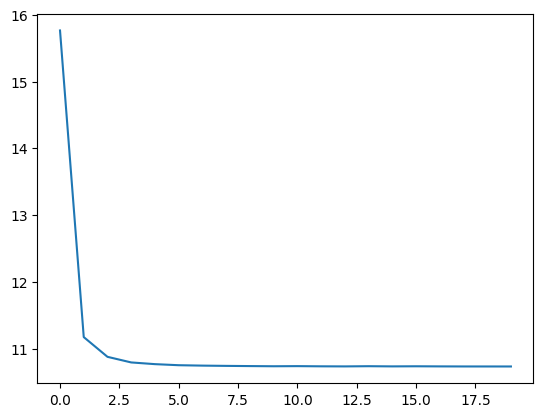

In [11]:
plt.plot(history.history['reconstruction_loss'])

In [12]:
_, _, z = encoder(dist)
reconstruction, log_var_x = decoder(z)

In [13]:
tf.reduce_mean(tf.exp(log_var_x/2), axis = 0)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1.9929535 , 1.0287373 , 1.0225314 , 1.0199372 , 0.97832423,
       1.0008725 , 1.0165682 , 1.0079604 , 1.0118271 , 1.0141804 ,
       1.0038834 , 0.9991672 , 0.99205136, 1.0005666 , 1.0163355 ,
       0.99895704, 1.0161605 , 0.98566926, 0.9919051 , 0.98901486],
      dtype=float32)>

In [14]:
X_hat = np.random.normal(loc= reconstruction, scale=tf.exp(log_var_x/2))
X_hat.shape

(10000, 20)

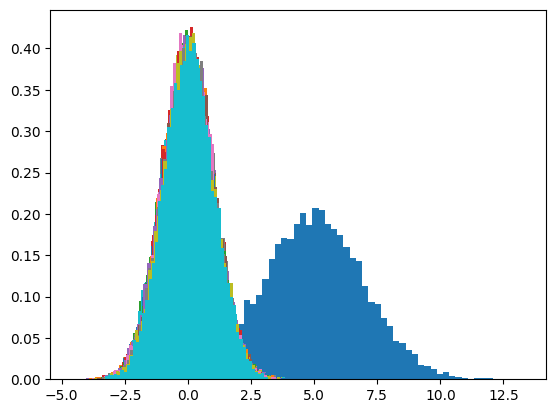

In [15]:
#plt.scatter(z[:, 0], z[:, 1])
for i in range(20):
    plt.hist(X_hat[:,i], density=True, bins = 'auto');


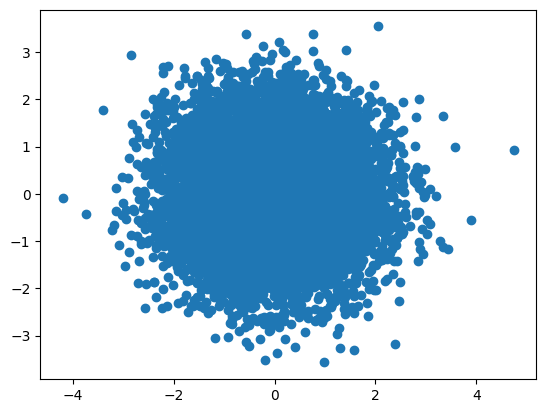

In [16]:
plt.scatter(z[:, 0], z[:, 1]);

In [17]:
#Simulation of a truncated normal distribution 
def truncatedDistribution(n_samples,  mean, variance,  bound):
    sd = np.sqrt(variance)
    L = list()
    i = 0 
    while i < n_samples:
        prop = np.random.normal(loc = mean, scale=sd)
        #prop_norm = np.linalg.norm(prop[0:2], ord=-np.inf)

        if prop[0] > bound : 
            L.append(prop)
            i += 1
            if i %10 == 0:
                clear_output(wait=True)
                print("boucle %d terminée" %(i))

    return np.array(L)

In [18]:
dist = truncatedDistribution(10000, np.zeros(20), np.ones(20), 2 )

boucle 10000 terminée


In [19]:
np.std(dist[:, 0])

0.345784841611076

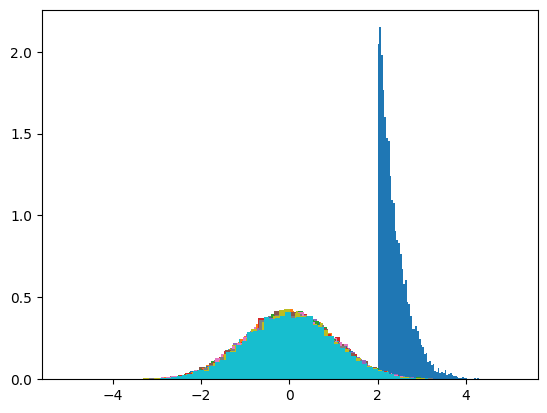

In [20]:
for i in range(20):
    plt.hist(dist[:, i], density= True, bins='auto')

In [21]:
encoder = Encoder(2)
decoder = Decoder(2)
vae = VAE(encoder, decoder, optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3))
vae.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3))
vae.fit(dist, epochs= 20, batch_size=32)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - Total_loss: 13.7066 - kl_loss: 1.7477 - loss: 0.0000e+00 - reconstruction_loss: 11.9589
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 10.0407 - kl_loss: 0.0121 - loss: 0.0000e+00 - reconstruction_loss: 10.0286
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 9.4216 - kl_loss: 0.0024 - loss: 0.0000e+00 - reconstruction_loss: 9.4193
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - Total_loss: 8.9464 - kl_loss: 7.8242e-04 - loss: 0.0000e+00 - reconstruction_loss: 8.9456
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 9.0337 - kl_loss: 3.3275e-04 - loss: 0.0000e+00 - reconstruction_loss: 9.0334
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 9.0155 - kl_loss: 1.7735e-04 - loss: 0.0000e+00 - reconstruction_loss: 9.0154
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Total_loss: 8.9963 - kl_loss: 1.1867e-04 - loss: 0.0000e+00 - reconstruction_loss: 8.9962


In [22]:
_,_, z = encoder(dist)
mean_x, log_var_x = decoder(z)

samples = np.random.normal(loc= mean_x, scale= tf.exp(log_var_x /2))
samples.shape

(10000, 20)

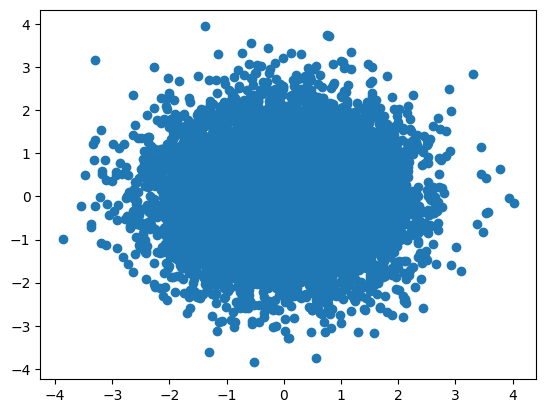

In [23]:
plt.scatter(z[:, 0], z[:, 1])

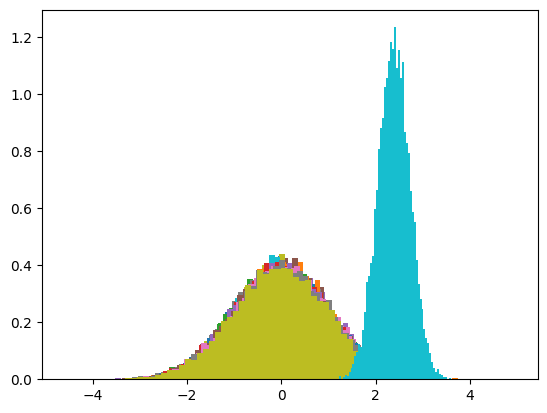

In [24]:
for i in range(1,20):
    plt.hist(samples[:,i], density=True, bins='auto');
plt.hist(samples[:, 0], density=True, bins='auto');

In [25]:
print(f"La moyenne empirique de la  1er composante {np.mean(mean_x, axis=0)[0]} et la moyenne théorique  {sp.norm.pdf(2)/(1-sp.norm.cdf(2))}" )
print(f"Moyenne empirique {np.mean(tf.exp(log_var_x/2), axis = 0 )[0]}, moyenne théorique {np.sqrt(1 - sp.norm.pdf(2)/(1-sp.norm.cdf(2)) * (sp.norm.pdf(2)/(1-sp.norm.cdf(2)) - 2))}")

La moyenne empirique de la  1er composante 2.3906636238098145 et la moyenne théorique  2.373215532822841
Moyenne empirique 0.33975833654403687, moyenne théorique 0.33805191970181275


In [2]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
batch_size = [32, 64]
epochs = [10, 20]
lr = [1e-2, 1e-3, 1e-4]
#utilisation de Keras Classifier 
param_grid = dict(batch_size=batch_size, epochs=epochs, lr = lr)
grid = GridSearchCV(estimator=vae, param_grid=param_grid, n_jobs=-1, cv=3)